# GeoSeg Inference 

Conda env: conda activate geoseg

In [1]:
import os as os
import numpy as np
import torch as torch
from torch import nn
from torch.utils.data import DataLoader
import tqdm as tqdm
import multiprocessing
import models.model_config.abcnet as config
from models.model_config.model_loader import *


from models.ABCNet import *
from data_processing.Urban_dataset import *
from data_processing.transform import *

/home/jupyter-dai7591/.conda/envs/geoseg/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jupyter-dai7591/.conda/envs/geoseg/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Load dataset

In [2]:
import os

train_images_dir = 'data/Urban/train/images'
train_masks_dir = 'data/Urban/train/masks'

val_images_dir = 'data/Urban/val/images'
val_masks_dir = 'data/Urban/val/masks'

# Count files
num_images = len([f for f in os.listdir(train_images_dir) if os.path.isfile(os.path.join(train_images_dir, f))])
num_masks = len([f for f in os.listdir(train_masks_dir) if os.path.isfile(os.path.join(train_masks_dir, f))])

print(f"Number of image files in train: {num_images}")
print(f"Number of mask files in train: {num_masks}")

# Count files
num_images = len([f for f in os.listdir(val_images_dir) if os.path.isfile(os.path.join(val_images_dir, f))])
num_masks = len([f for f in os.listdir(val_masks_dir) if os.path.isfile(os.path.join(val_masks_dir, f))])

print(f"Number of image files in val: {num_images}")
print(f"Number of mask files in val: {num_masks}")

Number of image files in train: 1156
Number of mask files in train: 1156
Number of image files in val: 677
Number of mask files in val: 677


In [13]:
train_data_root = 'data/Urban/train' 
val_data_root = 'data/Urban/val' 

# Define device
gpu_index = 0
device = torch.device(f"cuda:{gpu_index}" if torch.cuda.is_available() else "cpu")
print(device)


# Dataset 
val_dataset = UrbanDataset(data_root=val_data_root,
                             mode='test',
                             augmentation=val_aug)


val_loader = DataLoader(val_dataset,
                          batch_size=2,
                          shuffle=True, 
                          num_workers=7,
                          pin_memory=True) # True when running on cuda

cuda:0


## Load the model

In [4]:
# Model
#model = Supervision_Train('geoseg/model_config/abcnet.py')

model = Supervision_Train.load_from_checkpoint(
    os.path.join(config.weights_path, config.test_weights_name + '.ckpt'), config=config)

model.to(device)
model.eval()

Supervision_Train(
  (net): ABCNet(
    (cp): ContextPath(
      (resnet): FeatureListNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (drop_block): Identity()
            (act1): ReLU(inplace=True)
            (aa): Identity()
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act2): ReLU(inplace=

## Create masks! 

In [15]:
# True saves RGB masks for visualization
# False saves indexed PNG for SESSRS
rgb_output = True 
output_path = "data/output_masks_loveda" # base output folder

# Make output dirs
os.makedirs(os.path.join(output_path, 'pre_rgb'), exist_ok=True)
os.makedirs(os.path.join(output_path, 'pre_p'), exist_ok=True)

def multipool(function, args, processes=40):
    # Create a pool of worker processes for parallel execution
    pool = multiprocessing.Pool(processes=processes)
    
    # Create a progress bar with the total number of tasks
    with tqdm.tqdm(total=len(args)) as pbar:
        # For each result returned by the worker pool (order is not guaranteed)
        for result in pool.imap_unordered(function, args):
            # (Optional) You could process the result here if needed
            # Update the progress bar for each completed task
            pbar.update(1)

    # Close the pool to prevent new tasks from being submitted
    pool.close()
    # Wait for all worker processes to finish
    pool.join()


with torch.no_grad():  # Disable gradient computation for inference (saves memory and speeds up)
    results = []             # List to store mask saving arguments
    for input in tqdm.tqdm(val_loader):  # Iterate over the test data with a progress bar
        # raw_prediction NxCxHxW
        raw_predictions = model(input['img'].to(device))  # Run model on input images (N, C, H, W)
        image_ids = input['img_id']                       # Get the image IDs for the batch
        raw_predictions = nn.Softmax(dim=1)(raw_predictions)  # Convert logits to probabilities
        predictions = raw_predictions.argmax(dim=1)           # Get predicted class per pixel (N, H, W)

        for i in range(raw_predictions.shape[0]):
            mask = predictions[i].cpu().numpy()
            mask_id = image_ids[i]
            mask_name = mask_id
            results.append((mask, output_path, mask_name, rgb_output))


# Use multiprocessing to save all masks in parallel, showing a progress bar
multipool(img_writer, results)

100%|██████████| 677/677 [00:07<00:00, 92.63it/s] 


## Visualize each step

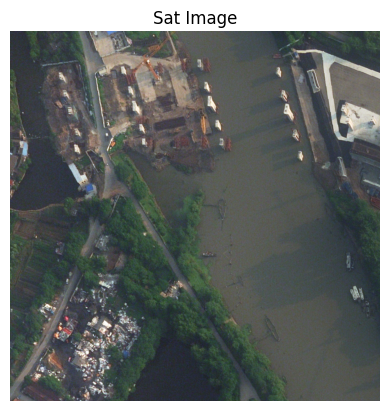

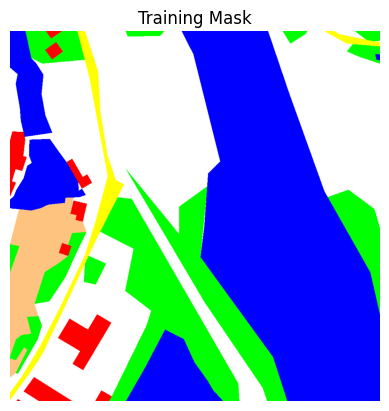

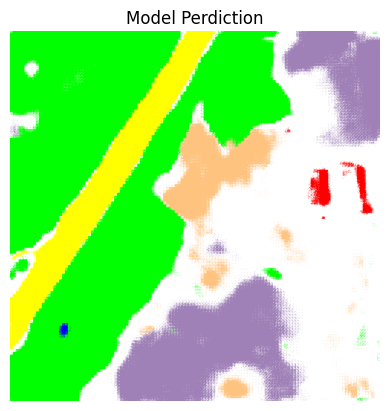

('background', 'building', 'road', 'water', 'barren', 'forest', 'agricultural', 'other')
[255, 255, 255, 255, 0, 0, 255, 255, 0, 0, 0, 255, 159, 129, 183, 0, 255, 0, 255, 195, 128, 0, 0, 0]


In [33]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_id = 1400
first_img_index = 1366
index = img_id - 1366 # ID of the first image
first_mask_index = 3514
mask_id = first_mask_index + index

sat_image = f"data/Urban/train/images/{img_id}.png"  

img = mpimg.imread(sat_image)
plt.imshow(img)
plt.axis('off') 
plt.title("Sat Image") 
plt.show()

train_mask = f"data/Urban/train/masks/{img_id}.png"  
img = mpimg.imread(train_mask)
plt.imshow(img)
plt.axis('off') 
plt.title("Training Mask") 
plt.show()

model_perdict = f"data/output_masks_loveda/pre_rgb/{mask_id}.png"  
img = mpimg.imread(model_perdict)
plt.imshow(img)
plt.axis('off') 
plt.title("Model Perdiction") 
plt.show()

print(CLASSES)
print(palette)